# Time Series Forecast

> Menggunakan data historikal penjualan Olist E-Commerce, akan dailakukan sales forecasting di masa yang akan datang menggunakan time series forecast. Adapun data yang dibutuhkan pada model ini merupakan data time series penjualan serta jumlah penjualan historikal yang berhasil dilakukan oleh Olist

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from pandas import Series
import itertools
import warnings                 
warnings.filterwarnings("ignore")

In [2]:
df_cust = pd.read_csv('olist_customers_dataset.csv')
df_geo = pd.read_csv('olist_geolocation_dataset.csv')
df_order = pd.read_csv('olist_order_items_dataset.csv')
df_payment = pd.read_csv('olist_order_payments_dataset.csv')
df_review = pd.read_csv('olist_order_reviews_dataset.csv') #belum clean
df_delivery = pd.read_csv('olist_orders_dataset.csv')
df_product = pd.read_csv('olist_products_dataset.csv') #belum clean
df_seller = pd.read_csv('olist_sellers_dataset.csv')
df_catprod = pd.read_csv('product_category_name_translation.csv')

In [3]:
all_table = [df_cust, df_geo, df_order, df_payment, df_review, df_delivery, df_product, df_seller, df_catprod]
name_table = ['Data Customer', 'Data Geografis', 'Data Order', 'Data Payment', 'Data Review', 'Data Delivery', 'Data Produk', 'Data Seller','Data Kategori Produk']

# Data Pre Processing

> Data pre processing yang perlu dilakukan pada case ini adalah data filtering guna mendapatkan data yang diinginkan saja dan juga mengubah data tanggal yang semula merupkan type object menjadi type datetime

In [4]:
df_delivery.dropna(inplace=True)
index_to_drop = df_delivery[df_delivery['order_status']=='canceled'].index
df_sales_pred = df_delivery.drop(index=index_to_drop)
df_sales_pred = df_delivery.drop(columns=['order_approved_at','order_delivered_carrier_date',
                                          'order_delivered_customer_date','order_estimated_delivery_date'])
df_sales_pred = df_sales_pred.merge(df_order,left_on='order_id', 
                    right_on='order_id')[['order_purchase_timestamp','order_item_id']]
df_sales_pred.head()

,order_purchase_timestamp,order_item_id
0,2017-10-02 10:56:33,1
1,2018-07-24 20:41:37,1
2,2018-08-08 08:38:49,1
3,2017-11-18 19:28:06,1
4,2018-02-13 21:18:39,1


In [5]:
df_sales_pred['order_purchase_timestamp'] = pd.to_datetime(df_sales_pred.order_purchase_timestamp,format='%Y-%m-%d %H:%M')
df_sales_pred.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110180 entries, 0 to 110179
Data columns (total 2 columns):
order_purchase_timestamp    110180 non-null datetime64[ns]
order_item_id               110180 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.5 MB


In [6]:
df_sales_pred.index = df_sales_pred.order_purchase_timestamp 
# Hourly time series 
hourly = df_sales_pred.resample('H').sum()
hourly.dropna(inplace=True)
# Converting to daily mean 
daily = df_sales_pred.resample('D').sum()
daily.dropna(inplace=True)
# Converting to weekly mean 
weekly = df_sales_pred.resample('W').sum() 
weekly.dropna(inplace=True)
# Converting to monthly mean 
monthly = df_sales_pred.resample('M').sum()
monthly.dropna(inplace=True)

# EDA

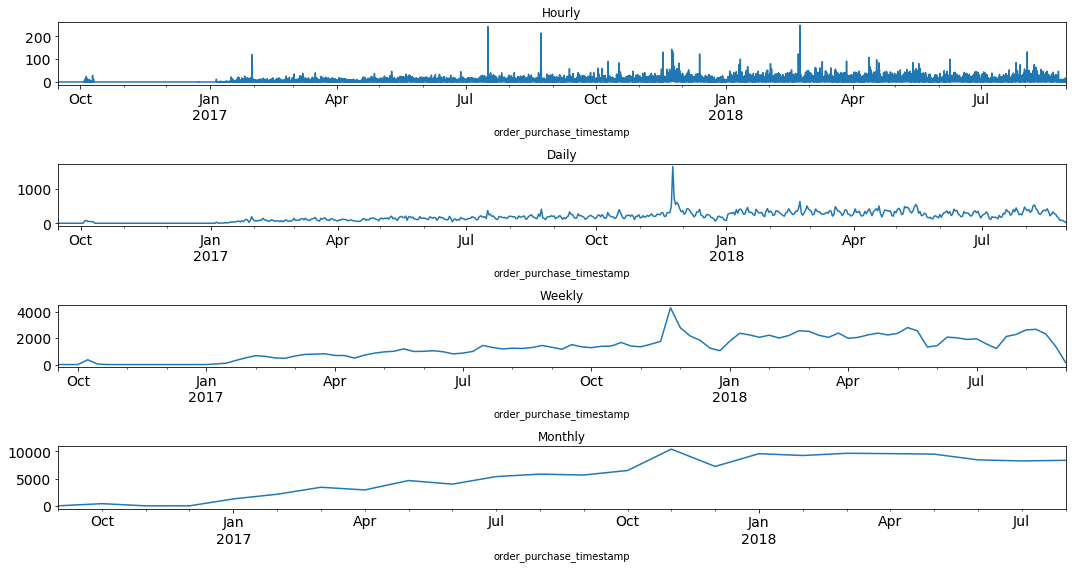

In [7]:
fig, axs = plt.subplots(4,1) 
hourly.order_item_id.plot(figsize=(15,8), title= 'Hourly', fontsize=14, ax=axs[0]) 
daily.order_item_id.plot(figsize=(15,8), title= 'Daily', fontsize=14, ax=axs[1]) 
weekly.order_item_id.plot(figsize=(15,8), title= 'Weekly', fontsize=14, ax=axs[2]) 
monthly.order_item_id.plot(figsize=(15,8), title= 'Monthly', fontsize=14, ax=axs[3])

plt.tight_layout()
plt.show()

In [8]:
# split data using daily data
df_sptrain = daily.ix['2017-01-05':'2018-05-01']
df_sptest = daily.ix['2018-05-01':'2018-08-20'] 

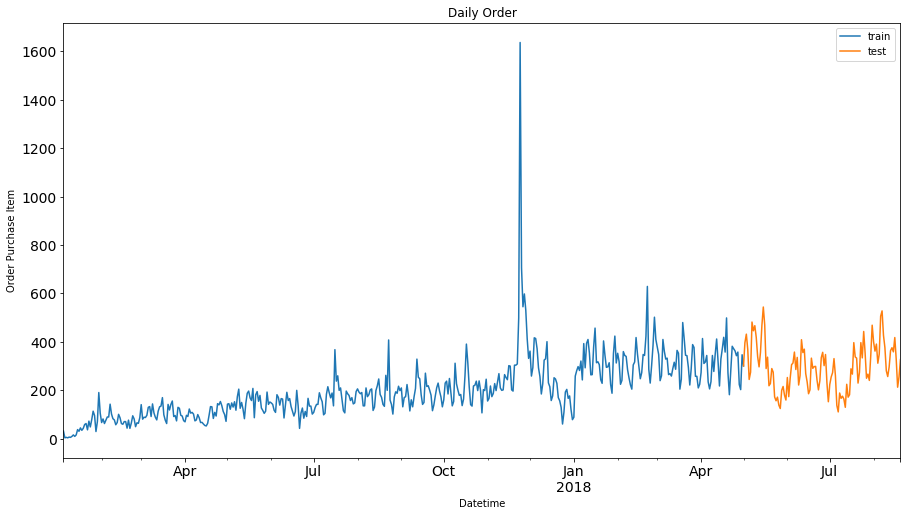

In [9]:
df_sptrain.order_item_id.plot(figsize=(15,8), title= 'Daily Order', fontsize=14, label='train') 
df_sptest.order_item_id.plot(figsize=(15,8), title= 'Daily Order', fontsize=14, label='test') 
plt.xlabel("Datetime") 
plt.ylabel("Order Purchase Item") 
plt.legend(loc='best') 
plt.show()

# Data Modelling

In [10]:
# p = d = q = range(0, 2)
# pdq = list(itertools.product(p, d, q))
# seasonal_pdq = [(x[0], x[1], x[2], 28) for x in list(itertools.product(p, d, q))]
# for param in pdq:
#     for param_seasonal in seasonal_pdq:
#         try:
#             mod = sm.tsa.statespace.SARIMAX(df_sptrain.order_item_id,
#                                             order=param,seasonal_order=param_seasonal,
#                                             enforce_stationarity=False,
#                                             enforce_invertibility=False)
#             results = mod.fit()
#             print('SARIMAX{}x{}- AIC:{}'.format(param,param_seasonal,results.aic))
#         except: 
#             continue

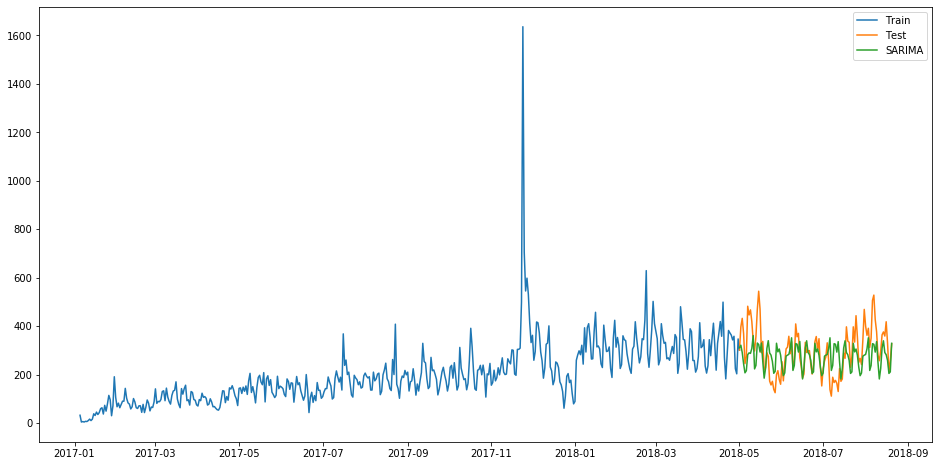

In [11]:
import statsmodels.api as sm
y_hatavg = df_sptest.copy() 
fit1 = sm.tsa.statespace.SARIMAX(df_sptrain.order_item_id, order=(1, 0, 1),seasonal_order=(1, 1, 1, 28)).fit() 
y_hatavg['SARIMA'] = fit1.predict(start='2018-05-01', end='2018-08-29', dynamic=True) 
plt.figure(figsize=(16,8)) 
plt.plot(df_sptrain['order_item_id'], label='Train') 
plt.plot(df_sptest['order_item_id'], label='Test') 
plt.plot(y_hatavg['SARIMA'], label='SARIMA') 
plt.legend(loc='best') 
plt.show()

In [12]:
df_sp_train=df_sptrain.reset_index()
df_sp_test=df_sptest.reset_index()
y_hat_avg=y_hatavg.reset_index()

In [13]:
import pickle
filename = 'df_sp_train.sav'
pickle.dump(df_sp_train, open(filename , 'wb'))

filename = 'df_sp_test.sav'
pickle.dump(df_sp_test, open(filename , 'wb'))

filename = 'y_hat_avg.sav'
pickle.dump(y_hat_avg, open(filename , 'wb'))

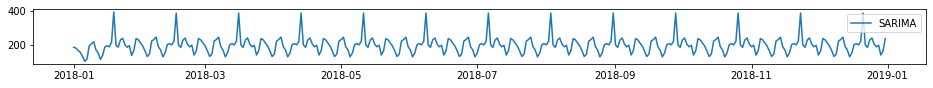

In [14]:
tes = fit1.predict(start='2018-01-01', end='2018-12-31', dynamic=True) 
plt.figure(figsize=(16,1)) 
plt.plot(tes, label='SARIMA') 
plt.legend(loc='best') 
plt.show()

In [15]:
data_forecast = pd.DataFrame(tes).reset_index()

In [16]:
data_forecast=data_forecast.rename(columns={'index':'Date',0:'order'})

In [17]:
filename = 'data_forecast.sav'
pickle.dump(data_forecast, open(filename , 'wb'))

In [18]:
pd.DataFrame(tes,columns=['predict_order']).head()

,predict_order
2018-01-01,186.761027
2018-01-02,182.523667
2018-01-03,168.371353
2018-01-04,157.036244
2018-01-05,132.463839


In [19]:
from sklearn.metrics import mean_absolute_error
from math import sqrt 
mae = mean_absolute_error(df_sp_test.order_item_id, y_hat_avg['SARIMA'])
print(mae)

70.1812169844047


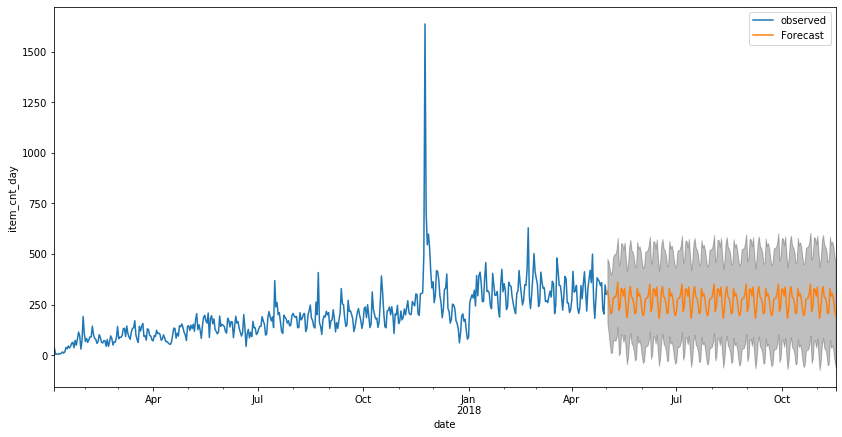

In [20]:
pred_uc = fit1.get_forecast(steps=200)
pred_ci = pred_uc.conf_int()
ax = df_sptrain.order_item_id.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('date')
ax.set_ylabel('item_cnt_day')
plt.legend()
plt.show()

**Conclusion :**

> Berdasarkan visualisasi dan hasil prediksi yang diperoleh, dapat kita simpulkan bahwa tren untuk historikal sales di Olist E-commerce cenderung stagnan (tidak terdapat trend peningkatan atau penurunan) sehingga hasil prediksi yang dihasilkanpun cenderung fluktuatif namun tanpa trend peningkatan atau penurunan. Bila kedepannya olist masih menggunakan strategi yang sama persis dalam bisnisnya, sales predict di atas dapat menjadi gambaran kemungkinan penjualan yang akan didapatkan oleh olist kedepannya. 